In [65]:
import requests
import pandas as pd

In [66]:
url_method = 'https://api.hh.ru/vacancies' # Базовый URL API HH с методом 'vacancies'
area = '1' # Регион Москва. Даные найдены в каталоге /areas
date_from = '2023-09-01' # Дата начала поиска
date_to = '2023-10-12' # Дата конца поиска
text = "NAME:(Data Scientist OR Machine Learning Engineer OR ML Engineer)" # Текстовый запрос вакансий с применением языка поисковых запросов HH

In [67]:
def api_request(page_number: str):
    
    payload = {'area' : area, 'date_from' : date_from,
               'date_to' : date_to, 'text' : text,
               'per_page' : '100', 'page' : str(page_number)}
    
    headers = { "User-Agent": "api_agent" }
    
    response = requests.get(url_method, params=payload, headers=headers)
    data = response.json()
    response.close()
    return data

In [68]:
def getVacancies():
    page_number = 0
    df = pd.DataFrame()
    while len(api_request(page_number=page_number).get("items", [])) > 0:
        data = api_request(page_number=page_number).get("items", [])
        for i in range(len(data)):
            row_dict = {
                'id' : data[i]['id'],
                'name' : data[i]['name'],
                'published_at' : data[i]['published_at'][:10],
                'employer_name' : data[i]['employer']['name'],
                'schedule' : data[i]['schedule']['id'],
                'experience' : data[i]['experience']['id'],
                'employment' : data[i]['employment']['id'],
                'geo_north' : [data[i]['address']['lat'] if data[i]['address'] is not None else 'No data'],
                'geo_east' : [data[i]['address']['lng'] if data[i]['address'] is not None else 'No data']
            }
            
            df_row = pd.DataFrame(row_dict, index=[0])
            df = pd.concat([df, df_row])
        page_number += 1
    
    return df

vacancies_df = getVacancies()

In [69]:
vacancies_df.describe()

,id,name,published_at,employer_name,schedule,experience,employment,geo_north,geo_east
count,246,246,246,246,246,246,246,242,242
unique,246,191,25,122,4,4,2,65,65
top,88054843,Data Scientist,2023-09-25,СБЕР,fullDay,between3And6,full,No data,No data
freq,1,24,24,44,169,144,242,161,161


<Axes: xlabel='employer_name'>

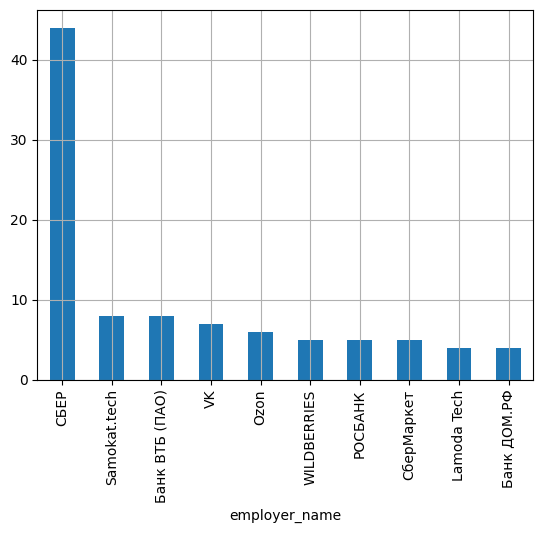

In [74]:
top_emp = vacancies_df.groupby('employer_name')['id'].count().nlargest(10)

top_emp.plot(kind='bar', grid=True)

### На долю какой компании пришлось больше всего опубликованных вакансий?

Больше всего вакансий опубликовала компания CБЕР, целых 44 штуки!

<Axes: xlabel='published_at'>

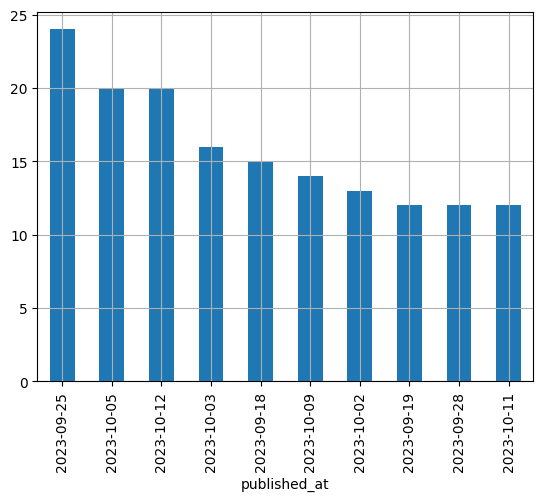

In [71]:
dates = vacancies_df.groupby('published_at')['id'].count().nlargest(10)

dates.plot(kind='bar', grid=True)

Больше всего вакансий было опубликовано 25 сентября. Между прочим, в эту дату празднуется день Фармацевта. Совпадение? Не думаю... 

In [72]:
vacancies_df.to_csv('./hh.csv', index=False)